# Correlate normalized UPDRS and find correlation that needs to beaten

In [1]:
%load_ext autoreload
%autoreload 2
from analysis_settings import *
from plot_settings import *
from scripts.utils_plot import _save_fig, _corr_results, _axes2d, plot_corr, plot_corrs, convert_pvalue_to_asterisks
import pandas as pd
import scripts.config as cfg
from os.path import join
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression
import numpy as np
from itertools import combinations, chain

In [2]:
n_perm = 10000
# n_perm = None

In [3]:
ch_choice = 'ch_dist_sweet'
dataframes = get_dfs(ch_choice)

df_norm = dataframes['df_norm']
df_abs = dataframes['df_abs']
df_per = dataframes['df_per']
# df_abs260 = dataframes['df_abs260']
# df_lor = dataframes['df_lor100']
df_sample_sizes = dataframes['df_sample_sizes']

df_norm = df_norm[~df_norm.project.isin(['all'])]
df_norm_offon = df_norm[df_norm.cond.isin(['offon_abs'])]
df_norm_on = df_norm[df_norm.cond.isin(['on'])]
df_norm_off = df_norm[df_norm.cond.isin(['off'])
                      ]
df_abs = df_abs[~df_abs.project.isin(['all'])]
df_abs_off = df_abs[df_abs.cond.isin(['off'])]
df_abs_on = df_abs[df_abs.cond.isin(['on'])]

df_per = df_per[~df_per.project.isin(['all'])]
df_per_off = df_per[df_per.cond.isin(['off'])]
df_per_on = df_per[df_per.cond.isin(['on'])]
# df_abs260 = df_abs260[df_abs260.cond.isin(['off']) & df_abs260.project.isin(['all'])]
# df_lor = df_lor[df_lor.cond.isin(['off']) & df_lor.project.isin(['all'])]

/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot['UPDRS_exists'] = pivot.UPDRS_bradyrigid_contra.notna()
/Users/moritzgerster/Library/CloudStorage/Dropbox/Code/STN_broadband_power/notebooks/analysis_settings.py:82: 

In [4]:
def f_test(sum_squares_resid1, sum_squares_resid2, dof1, dof2,
           model_nme1='Model 1', model_nme2='Model 2'):
    if dof1 == dof2:
        f_stat = sum_squares_resid1 / sum_squares_resid2
        p_value = 1 - stats.f.cdf(f_stat, dof1, dof2)
    else:
        f_stat = ((sum_squares_resid1 - sum_squares_resid2) / (dof1 - dof2)) / (sum_squares_resid2 / dof2)
        p_value = 1 - stats.f.cdf(f_stat, dof1 - dof2, dof2)
    print(f'{model_nme2} (same or more parameters) is better than {model_nme1} at p={p_value}')
    return p_value


def _corrected_aic(model):
    """Correct AIC for small sample sizes."""
    aic = model.aic
    n_features = model.params.shape[0]
    sample_size = model.nobs
    correction = (2 * n_features**2 + 2 * n_features) / (sample_size - n_features - 1)
    AICc = aic + correction
    return AICc


def all_combinations(any_list, max_len=None):
    if max_len == None:
        max_len = len(any_list)
    return chain.from_iterable(combinations(any_list, i + 1)
                               for i in range(max_len))


def plot_all(df, X, y, kind, add_constant=True, extension='', save=True):
    if isinstance(X, str):
        X = [X]
    # if isinstance(y, list):
    #     Y = [Y]
    X = X.copy()
    df = df.copy()
    df = df.dropna(subset=X+[y])
    if y == 'UPDRS_III':
        # average hemispheres
        keep = ['subject', 'cond', 'project', 'color']
        df = df.groupby(keep).mean(numeric_only=True).reset_index()

    # Linear regression
    X_arr = df[X].values
    if add_constant:
        X_arr = sm.add_constant(X_arr)
    y_arr = df[y].values
    # Calculate AIC and BIC
    model = sm.OLS(y_arr, X_arr).fit()
    coefficients = model.params
    # if add_constant:
    #     coefficients = coefficients[1:]
    sum_of_squared_residuals = model.ssr
    degrees_of_freedom = model.df_resid
    AICc_linreg = _corrected_aic(model)
    BIC_linreg = model.bic
    # if round(AICc) != round(model.aic):
    #     aic_str = f'AICc: {AICc:.0f}, AIC: {model.aic:.0f}'
    # else:
    #     aic_str = f'AIC: {model.aic:.0f}'
    if coefficients.ndim == 2:
        coefficients = coefficients[0]

    bands = [band.replace('_abs_mean_log', '').replace('_fm_mean_log', '')
             for band in X]
    bands = [cfg.BAND_NAMES_GREEK_SHORT[band] for band in bands]
    # feature_nme = f"Lin. reg. ({' '.join(X).replace(pwr_str, '')})"
    feature_nme = f"Lin. reg. ({', '.join(bands)})"
    # feature_nme = "Regression model"
    X.append(feature_nme)
    full_model_abic = f'AICc: {AICc_linreg:.0f}, BIC: {BIC_linreg:.0f}'
    print(f'{feature_nme} coefficients: {coefficients}')
    df[feature_nme] = [np.dot(coefficients, x) for x in X_arr]


    fig, axes = plt.subplots(1, len(X), figsize=(3.5, 1.3), sharey=True,
                             width_ratios=[1] * (len(X) - 1) + [1.5])
    for i, x in enumerate(X):
        add_sample_size = True if i == len(X)-1 else False
        x_arr = df[x].values
        if add_constant:
            x_arr = sm.add_constant(x_arr)
        model = sm.OLS(y_arr, x_arr).fit()
        AICc = _corrected_aic(model)
        BIC = model.bic
        # if round(AICc) != round(model.aic):
        #     aic_str = f'AICc: {AICc:.0f}, AIC: {model.aic:.0f}'
        # else:
        #     aic_str = f'AIC: {model.aic:.0f}'
        if i != len(X)-1:
            model_abic = f'AICc: {AICc:.0f}, BIC: {BIC:.0f}'
        else:
            model_abic = full_model_abic
        corr_results = _corr_results(df, x, y,
                                     'pearson',
                                    #  'spearman',
                                     None,
                                     add_sample_size=add_sample_size,
                                    #  pval_string=False,
                                    n_perm=n_perm
                                    )
        r_pearson, sample_size, label, weight, _ = corr_results
        pvalue = float(label.split('p=')[1])
        ax = axes[i]
        kind_color = 'periodicAP' if x in ['fm_offset_log', 'fm_exponent', 'fm_exponent_narrow'] else kind
        color = cfg.COLOR_DIC[kind_color]
        sns.regplot(ax=ax, data=df, y=y, x=x, ci=95, scatter_kws=dict(s=1),
                    color=color, label=label, marker='.', n_boot=1000)

        try:
            xlabel = cfg.PLOT_LABELS[x].replace(' mean', '')
        except KeyError:
            xlabel = x
        print(f'{xlabel}: {label}, {model_abic}')
        # xlabel = cfg.BAND_NAMES_GREEK_SHORT[x]
        ax.set_xlabel(xlabel)
        ax.set_ylabel(None)
        # if i == 0:
        #     label = label[:17]
        # if i != len(X)-1:
            # label = f'r={rho:.2f}'
        ax.set_title(label, weight=weight)
    axes[0].set_ylabel('UPDRS-III')
    plt.tight_layout()
    fname = f'{kind}_regression_all_vs_{y}_{df.cond.unique()[0]}{extension}.pdf'
    save_dir = join(SAVE_DIR, 'Figure2', ch_choice)
    if save:
        _save_fig(fig, fname, save_dir, bbox_inches=None, close=False, transparent=True)
    plt.show()
    return r_pearson, pvalue, sum_of_squared_residuals, degrees_of_freedom, AICc_linreg, BIC_linreg


def plot_all_ax(ax, df, X, y, kind, add_constant=True, ylabel=False):
    if isinstance(X, str):
        X = [X]
    X = X.copy()
    df = df.copy()
    df = df.dropna(subset=X+[y])
    if y == 'UPDRS_III':
        # average hemispheres
        keep = ['subject', 'cond', 'project', 'color']
        df = df.groupby(keep).mean(numeric_only=True).reset_index()

    # Linear regression
    X_arr = df[X].values
    if add_constant:
        X_arr = sm.add_constant(X_arr)
    y_arr = df[y].values
    # Calculate AIC and BIC
    model = sm.OLS(y_arr, X_arr).fit()
    coefficients = model.params
    # if add_constant:
    #     coefficients = coefficients[1:]
    sum_of_squared_residuals = model.ssr
    degrees_of_freedom = model.df_resid
    AICc_linreg = _corrected_aic(model)
    BIC_linreg = model.bic
    # if round(AICc) != round(model.aic):
    #     aic_str = f'AICc: {AICc:.0f}, AIC: {model.aic:.0f}'
    # else:
    #     aic_str = f'AIC: {model.aic:.0f}'
    if coefficients.ndim == 2:
        coefficients = coefficients[0]

    bands = [band.replace('_abs_mean_log', '').replace('_fm_mean_log', '')
             for band in X]
    bands = [cfg.BAND_NAMES_GREEK_SHORT[band] for band in bands]
    # feature_nme = f"Lin. reg. ({' '.join(X).replace(pwr_str, '')})"
    feature_nme = f"Lin. reg. ({', '.join(bands)})"
    # feature_nme = "Regression model"
    X.append(feature_nme)
    model_abic = f'AICc: {AICc_linreg:.0f}, BIC: {BIC_linreg:.0f}'
    print(f'{feature_nme} coefficients: {coefficients}')
    df[feature_nme] = [np.dot(coefficients, x) for x in X_arr]

    x = feature_nme
    add_sample_size = True
    corr_results = _corr_results(df, x, y, 'pearson', None,
                                 add_sample_size=add_sample_size,
                                 n_perm=n_perm)
    r_pearson, sample_size, label, weight, _ = corr_results
    pvalue = float(label.split('p=')[1])
    kind_color = 'periodicAP' if x in ['fm_offset_log', 'fm_exponent', 'fm_exponent_narrow'] else kind
    color = cfg.COLOR_DIC[kind_color]
    sns.regplot(ax=ax, data=df, y=y, x=x, ci=95, scatter_kws=dict(s=1),
                color=color, label=label, marker='.', n_boot=1000)

    try:
        xlabel = cfg.PLOT_LABELS[x].replace(' mean', '')
    except KeyError:
        xlabel = x
    print(f'{xlabel}: {label}, {model_abic}')
    ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel('UPDRS-III')
    else:
        ax.set_ylabel(None)
        ax.set_yticklabels([])
    ax.set_title(label, weight=weight)
    return r_pearson, pvalue, sum_of_squared_residuals, degrees_of_freedom, AICc_linreg, BIC_linreg

In [5]:
def find_best_model(df, y, kind, bands=cfg.BANDS.keys(), power='mean',
                    n_models=3, max_params=3,
                    add_constant=True, extension='', save=True,
                    optimize='AIC+BIC'):
    if kind == 'periodic':
        pwr_str = f'_fm_{power}_log'
        # features = [f'{band}_fm_{power}_log' for band in bands]
    else:
        pwr_str = f'_abs_{power}_log'
    features = [band + pwr_str for band in bands]
    if kind == 'periodic':
        features += ['fm_offset_log', 'fm_exponent']
    feature_nme = "Regression model"
    df = df.copy()
    df = df.dropna(subset=features + [y])
    if y == 'UPDRS_III':
        # average hemispheres
        keep = ['subject', 'cond', 'project', 'color']
        df = df.groupby(keep).mean(numeric_only=True).reset_index()
    y_arr = df[y].values
    combinations = [list(l) for l in all_combinations(features, max_len=max_params)]

    # Test all combinations
    metrics = []
    models = []
    # AICs = []
    # BICs = []
    # ABICs = []
    for X in combinations:

        # Linear regression
        X_arr = df[X].values
        if add_constant:
            X_arr = sm.add_constant(X_arr)
        # Calculate AIC and BIC
        model = sm.OLS(y_arr, X_arr).fit()
        if optimize == 'AIC':
            AICc = _corrected_aic(model)
            metrics.append(AICc)
        elif optimize == 'BIC':
            metrics.append(model.bic)
        elif optimize == 'AIC+BIC':
            AICc = _corrected_aic(model)
            metrics.append(AICc + model.bic)
        models.append(model)
        # AICs.append(AICc)
        # BICs.append(model.bic)
        # ABICs.append(AICc + model.bic)

    # Sort models by metric
    sorted_idx = np.argsort(metrics)
    # Select and plot the n_models best models
    sorted_idx = sorted_idx[:n_models]
    sorted_features = [combinations[i] for i in sorted_idx]
    sorted_models = [models[i] for i in sorted_idx]
    for i, model in enumerate(sorted_models):

        coefficients = model.params
        if coefficients.ndim == 2:
            coefficients = coefficients[0]
        # sum_of_squared_residuals = model.ssr
        # degrees_of_freedom = model.df_resid
        # if round(AICc) != round(model.aic):
        #     aic_str = f'AICc: {AICc:.0f}, AIC: {model.aic:.0f}'
        # else:
        #     aic_str = f'AIC: {model.aic:.0f}'
        AICc = _corrected_aic(model)

        X = sorted_features[i]
        bands_kept = [band for band in bands if band + pwr_str in X]
        bands_kept = [cfg.BAND_NAMES_GREEK_SHORT[band] for band in bands_kept]
        # feature_nme = f"Lin. reg. ({' '.join(X).replace(pwr_str, '')})"
        feature_nme = f"Lin. reg. ({', '.join(bands_kept)})"
        full_model_abic = f'AICc: {AICc:.0f}, BIC: {model.bic:.0f}'
        print(f'{feature_nme} coefficients: {coefficients}')
        X_arr = df[X].values
        if add_constant:
            X_arr = sm.add_constant(X_arr)
        df[feature_nme] = [np.dot(coefficients, x) for x in X_arr]
        X.append(feature_nme)


        fig, axes = plt.subplots(1, len(X), figsize=(3.5, 1.3), sharey=True,
                                width_ratios=[1] * (len(X) - 1) + [1.5])
        for i, x in enumerate(X):
            add_sample_size = True if i == len(X)-1 else False
            x_arr = df[x].values
            if add_constant:
                x_arr = sm.add_constant(x_arr)
            model = sm.OLS(y_arr, x_arr).fit()
            AICc = _corrected_aic(model)
            # if round(AICc) != round(model.aic):
            #     aic_str = f'AICc: {AICc:.0f}, AIC: {model.aic:.0f}'
            # else:
            #     aic_str = f'AIC: {model.aic:.0f}'
            if i != len(X)-1:
                model_abic = f'AICc: {AICc:.0f}, BIC: {model.bic:.0f}'
            else:
                model_abic = full_model_abic
            corr_results = _corr_results(df, x, y, 'pearson', None,
                                        add_sample_size=add_sample_size,
                                        #  pval_string=False,
                                        n_perm=n_perm
                                        )
            rho, sample_size, label, weight, _ = corr_results
            ax = axes[i]
            kind_color = 'periodicAP' if x in ['fm_offset_log', 'fm_exponent', 'fm_exponent_narrow'] else kind
            color = cfg.COLOR_DIC[kind_color]
            sns.regplot(ax=ax, data=df, y=y, x=x, ci=95, scatter_kws=dict(s=1),
                        color=color, label=label, marker='.', n_boot=1000)

            try:
                xlabel = cfg.PLOT_LABELS[x].replace(' mean', '')
            except KeyError:
                xlabel = x
            print(f'{xlabel}: {label}, {model_abic}')
            # xlabel = cfg.BAND_NAMES_GREEK_SHORT[x]
            ax.set_xlabel(xlabel)
            ax.set_ylabel(None)
            # if i == 0:
            #     label = label[:17]
            # if i != len(X)-1:
                # label = f'r={rho:.2f}'
            ax.set_title(label, weight=weight)
        axes[0].set_ylabel('UPDRS-III')
        plt.tight_layout()
        # fname = f'{kind}_regression_all_vs_{y}_{df.cond.unique()[0]}{extension}.pdf'
        # save_dir = join(SAVE_DIR, 'Figure2', ch_choice)
        # if save:
        #     _save_fig(fig, fname, save_dir, bbox_inches=None, close=False, transparent=True)
        plt.show()

## Correlate relative power with UPDRS Off

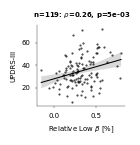

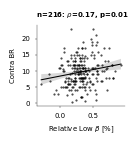

In [6]:
# x = 'beta_low_abs_max_log'
x = 'beta_low_abs_mean_log'
y = 'UPDRS_III'
corr_method = 'spearman'

y_vals = ['UPDRS_III', 'UPDRS_bradyrigid_contra']

for y in y_vals:
    df_plot = df_norm_off

    if y == 'UPDRS_III':
        # average hemispheres
        keep = ['subject', 'cond', 'project', 'color']
        df_plot = df_plot.groupby(keep).mean(numeric_only=True).reset_index()


    corr_results = _corr_results(df_plot, x, y, corr_method, None,
                                n_perm=n_perm
                                )
    rho, sample_size, label, weight, _ = corr_results

    df_plot = df_plot.dropna(subset=[x, y])

    fig, ax = plt.subplots(figsize=(1.3, 1.4))

    sns.regplot(ax=ax, data=df_plot, y=y, x=x, ci=95, scatter_kws=dict(s=1),
                color='k', label=label, marker='.', n_boot=1000)

    ax.set_title(label, weight=weight)
    # band_nme = x.replace('_abs_max_log', '')
    band_nme = x.replace('_abs_mean_log', '')
    band_label = cfg.BAND_NAMES_GREEK[band_nme]
    ax.set_xlabel(f'Relative {band_label} [%]')
    ax.set_ylabel(cfg.PLOT_LABELS[y])
    plt.tight_layout()
    fname = f'norm_{band_nme}_vs_{y}_off.pdf'
    save_dir = join(SAVE_DIR, 'Figure1', 'ch_dist_sweet')
    _save_fig(fig, fname, save_dir, bbox_inches=None, close=False, transparent=True)

## Off-On

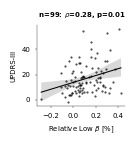

In [7]:
y = 'UPDRS_III'

df_plot = df_norm_offon

if y == 'UPDRS_III':
    # average hemispheres
    keep = ['subject', 'cond', 'project', 'color']
    df_plot = df_plot.groupby(keep).mean(numeric_only=True).reset_index()


corr_results = _corr_results(df_plot, x, y, corr_method, None,
                             n_perm=n_perm
                             )
rho, sample_size, label, weight, _ = corr_results

df_plot = df_plot.dropna(subset=[x, y])

fig, ax = plt.subplots(figsize=(1.3, 1.4))

sns.regplot(ax=ax, data=df_plot, y=y, x=x, ci=95, scatter_kws=dict(s=1),
            color='k', label=label, marker='.', n_boot=1000)

ax.set_title(label, weight=weight)
# band_nme = x.replace('_abs_max_log', '')
band_nme = x.replace('_abs_mean_log', '')
band_nme = cfg.BAND_NAMES_GREEK[band_nme]
ax.set_xlabel(f'Relative {band_nme} [%]')
ax.set_ylabel('UPDRS-III')
plt.tight_layout()
fname = 'norm_beta_low_vs_UPDRS_offon.pdf'
save_dir = join(SAVE_DIR, 'Figure1', 'ch_dist_sweet')
_save_fig(fig, fname, save_dir, bbox_inches=None, close=False, transparent=True)

## Bradyrigid contra

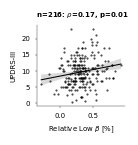

In [8]:
df_plot = df_norm_off
y = 'UPDRS_bradyrigid_contra'
if y == 'UPDRS_III':
    # average hemispheres
    keep = ['subject', 'cond', 'project', 'color']
    df_plot = df_plot.groupby(keep).mean(numeric_only=True).reset_index()


corr_results = _corr_results(df_plot, x, y, corr_method, None,
                             n_perm=n_perm
                             )
rho, sample_size, label, weight, _ = corr_results

df_plot = df_plot.dropna(subset=[x, y])

fig, ax = plt.subplots(figsize=(1.3, 1.4))

sns.regplot(ax=ax, data=df_plot, y=y, x=x, ci=95, scatter_kws=dict(s=1),
            color='k', label=label, marker='.', n_boot=1000)

ax.set_title(label, weight=weight)
# band_nme = x.replace('_abs_max_log', '')
band_nme = x.replace('_abs_mean_log', '')
band_nme = cfg.BAND_NAMES_GREEK[band_nme]
ax.set_xlabel(f'Relative {band_nme} [%]')
ax.set_ylabel('UPDRS-III')
plt.tight_layout()
fname = 'norm_beta_low_vs_BR_off.pdf'
save_dir = join(SAVE_DIR, 'Figure1', 'ch_dist_sweet')
_save_fig(fig, fname, save_dir, bbox_inches=None, close=False, transparent=True)

# Figure 5

## Correlate multiple regression absolute power with UPDRS Off

## Absolute

In [9]:
y = 'UPDRS_III'

#### Model with same patients as periodic

In [10]:
# bands = ['delta', 'theta_alpha', 'beta_low', 'beta_high', 'gamma_low']
# find_best_model(df_abs_off__, y, 'absolute', n_models=3, max_params=3, bands=bands, optimize='AIC+BIC')

In [11]:
# find_best_model(df_abs_off__, y, 'absolute', n_models=3, max_params=3, bands=bands, optimize='AIC+BIC')

Lin. reg. ($\theta$, L$\beta$, L$\gamma$) coefficients: [ 26.62186102 -12.59043484  14.0083107  -10.43637296]
$\theta$: $r=$-0.31, p=5e-04, AICc: 941, BIC: 946
Low $\beta$: $r=$-0.04, p=0.67, AICc: 953, BIC: 958
Low $\gamma$: $r=$-0.16, p=0.08, AICc: 950, BIC: 955
Lin. reg. ($\theta$, L$\beta$, L$\gamma$):  n=119: $r=$0.42, p=1e-04, AICc: 935, BIC: 945


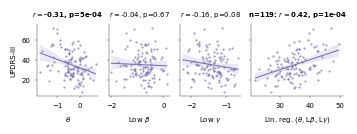

(np.float64(0.4168868118845096),
 0.0001,
 np.float64(16731.483730573458),
 np.float64(115.0),
 np.float64(934.6232021632977),
 np.float64(945.3888189427614))

In [12]:
X = ['theta_abs_mean_log', 'beta_low_abs_mean_log', 'gamma_low_abs_mean_log']
plot_all(df_abs_off, X, y, 'absolute')

In [13]:
# # average hemispheres
# keep = ['subject', 'cond', 'project', 'color']
# df_abs_off_mean = df_abs_off.groupby(keep).mean(numeric_only=True).reset_index()
# df_abs_off_mean = df_abs_off_mean.dropna(subset=X+[y])
# plot_corrs(df_abs_off_mean, 'theta_abs_mean_log', 'fm_offset_log')

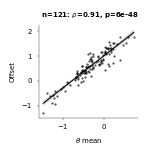

In [14]:
y = 'fm_offset_log'
x = 'theta_abs_mean_log'
corr_method = 'spearman'

# average hemispheres
keep = ['subject', 'cond', 'project', 'color']
df_plot = df_abs_off.groupby(keep).mean(numeric_only=True).reset_index()
df_plot = df_plot.dropna(subset=[x]+[y])

corr_results = _corr_results(df_plot, x, y, corr_method, None, n_perm=None)
rho, sample_size, label, weight, _ = corr_results

df_plot = df_plot.dropna(subset=[x, y])

fig, ax = plt.subplots(figsize=(1.5, 1.5))

sns.regplot(ax=ax, data=df_plot, y=y, x=x, ci=95, scatter_kws=dict(s=1),
            color='k', label=label, marker='.', n_boot=1000)

ax.set_title(label, weight=weight)
ax.set_xlabel(cfg.PLOT_LABELS[x])
ax.set_ylabel(cfg.PLOT_LABELS_SHORT[y])
plt.tight_layout()
fname = f'abs_{x}_vs_{y}_off.pdf'
save_dir = join(SAVE_DIR, 'Figure2', 'ch_dist_sweet')
_save_fig(fig, fname, save_dir, bbox_inches=None, close=False, transparent=True)

### Model comparison relative low beta power (1 parameter) with absolute linear regression (3 parameters)

https://sites.duke.edu/bossbackup/files/2013/02/FTestTutorial.pdf

Model 1: relative low beta power (fewer paramaters)

Model 2: absolute linear regression (more paramaters)

$SS_1$: Sum of squares of residuals for Model 1

$SS_2$: Sum of squares of residuals for Model 2

$dof_1$: degrees of freedom for Model 1

$dof_2$: degrees of freedom for Model 2

F-test formular: $\frac{(SS_1 - SS_2) / (dof_1 - dof_2)}{SS_2 / dof_2}$

In [15]:
# df_norm_off__ = df_norm_off[df_norm_off.sub_hemi.isin(df_per_off.sub_hemi.unique())]


# X = ['beta_low_abs_mean_log']
# r_linreg_rel, p_linreg_rel, ssr_rel1, dof_rel1, aic_rel, bic_rel = plot_all(df_norm_off__, X, y, 'normalized')

In [16]:
# find_best_model(df_norm_off__, y, 'normalized', n_models=3, optimize='BIC')
# find_best_model(df_norm_off__, y, 'normalized', n_models=3, max_params=3, bands=bands, optimize='AIC+BIC')

## Periodic

In [17]:
# find_best_model(df_abs_off__, y, 'periodic', n_models=3, max_params=3, bands=bands, optimize='AIC+BIC')

Lin. reg. (Offset, L$\beta$, L$\gamma$) coefficients: [ 38.2938942   -6.72255132  14.53509242 -45.08853012]
Offset: $r=$-0.32, p=4e-04, AICc: 911, BIC: 916
Low $\beta$: $r=$0.24, p=0.01, AICc: 917, BIC: 922
Low $\gamma$: $r=$-0.21, p=0.02, AICc: 918, BIC: 924
Lin. reg. (Offset, L$\beta$, L$\gamma$):  n=115: $r=$0.47, p=1e-04, AICc: 900, BIC: 910


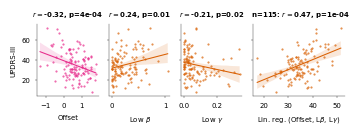

In [18]:
# full model
y = 'UPDRS_III'
X = ['fm_offset_log', 'beta_low_fm_mean_log', 'gamma_low_fm_mean_log']
r_linreg_per, p_linreg_per, ssr_per3, dof_per3, aic_per, bic_per = plot_all(df_per_off, X, y, 'periodic')

# Model comparison with corrected sample size

### Abssolute 3 bands is signficantly better than relative low beta band

In [19]:
# pval_norm_abs = f_test(ssr_rel1, ssr_abs3, dof_rel1, dof_abs3, model_nme1='Normalized', model_nme2='Absolute')

### 3 periodic parameters is better than relative beta alone

In [20]:
# pval_norm_per = f_test(ssr_rel1, ssr_per3, dof_rel1, dof_per3)

### 3 periodic parameters is not better than 3 absolute model

In [21]:
# pval_abs_per = f_test(ssr_abs3, ssr_per3, dof_abs3, dof_per3)

In [22]:
# n_perm = None
# # Plot model comparison
# y = 'UPDRS_III'
# kinds = ['normalized', 'absolute', 'periodic']
# xticklabels = [cfg.PLOT_LABELS[kind] for kind in kinds]
# colors = [cfg.COLOR_DIC[kind] for kind in kinds]


# fig, axes = plt.subplots(1, 4, figsize=(7, 1.7),
#                          width_ratios=[1, 1, 1, 1.5],
#                          gridspec_kw={'wspace': 0.15}
#                          )

# # # Share y-axis for the first three subplots
# # for ax in axes[:3]:
# #     ax.sharey(axes[0])  # Share y-axis with the first subplot

# # Normalized
# df_norm_off_ = df_norm_off[df_norm_off.sub_hemi.isin(df_per_off.sub_hemi.unique())]
# X = ['beta_low_abs_mean_log']
# r_linreg_rel, p_linreg_rel, ssr_rel1, dof_rel1, aic_rel, bic_rel = plot_all_ax(axes[0], df_norm_off_, X, y,
#                                                                                'normalized', ylabel=True)

# # Absolute
# X = ['theta_alpha_abs_mean_log', 'beta_low_abs_mean_log', 'gamma_low_abs_mean_log']
# df_abs_off_ = df_abs_off[df_abs_off.sub_hemi.isin(df_per_off.sub_hemi.unique())]
# r_linreg_abs, p_linreg_abs, ssr_abs3, dof_abs3, aic_abs, bic_abs = plot_all_ax(axes[1], df_abs_off_, X, y, 'absolute')

# # Periodic
# X = ['fm_offset_log', 'beta_low_fm_mean_log', 'gamma_low_fm_mean_log']
# r_linreg_per, p_linreg_per, ssr_per3, dof_per3, aic_per, bic_per = plot_all_ax(axes[2], df_per_off, X, y, 'periodic')

# # f-test model comparison
# pval_norm_abs = f_test(ssr_rel1, ssr_abs3, dof_rel1, dof_abs3, model_nme1='Normalized', model_nme2='Absolute')
# pval_norm_per = f_test(ssr_rel1, ssr_per3, dof_rel1, dof_per3, model_nme1='Normalized', model_nme2='Periodic')
# pval_abs_per = f_test(ssr_abs3, ssr_per3, dof_abs3, dof_per3, model_nme1='Absolute', model_nme2='Periodic')

# annotations = [('normalized', 'absolute', pval_norm_abs),
#                 ('absolute', 'periodic', pval_abs_per),
#                 ('normalized', 'periodic', pval_norm_per)]
# correlations = [r_linreg_rel, r_linreg_abs, r_linreg_per]
# pvalues = [p_linreg_rel, p_linreg_abs, p_linreg_per]

# # Barplot model comparison
# ax = axes[3]  # Adjust the last subplot's position
# # pos = ax.get_position()  # Get the current position
# # new_left = pos.x0 - 0.01  # Move to the right by increasing the left position
# # new_width = pos.width     # Keep the same width
# # ax.set_position([new_left, pos.y0, new_width, pos.height])

# ax.bar(x=xticklabels, height=correlations, color=colors)

# # Statistics
# bars = ax.containers[0]
# ymin, ymax = ax.get_ylim()
# yscale = np.abs(ymax - ymin)
# y_buffer = 0.03*yscale
# bar_x_coords = []
# for i, bar in enumerate(bars):
#     pvalue = pvalues[i]
#     text = convert_pvalue_to_asterisks(pvalue)
#     x_bar = bar.get_x() + bar.get_width() / 2
#     bar_x_coords.append(bar.get_x())
#     ax.annotate(text, xy=(x_bar, ymax + y_buffer), ha='center', va='top',
#                 fontsize=FONTSIZE_ASTERISK)

# height_stat = ymax + 1*y_buffer
# # Loop through each annotation
# for (x1_label, x2_label, pvalue) in annotations:
#     # Get the indices of the bars from the 'kinds' list
#     x1 = kinds.index(x1_label)
#     x2 = kinds.index(x2_label)

#     # Determine the y position for the line and asterisk
#     y_line = height_stat + 1.5*y_buffer  # Add some offset for the line
#     y_text = y_line + y_buffer/2  # Add a little more offset for the asterisks

#     # Draw the line connecting the two bars
#     ax.plot([x1, x1, x2, x2],
#             [y_line, y_line + y_buffer/2, y_line + y_buffer/2, y_line],
#             color='black')

#     # Get the significance text based on the p-value
#     text = convert_pvalue_to_asterisks(pvalue, print_ns=True)

#     # Place the text above the line
#     ax.text((x1 + x2) / 2, y_text, text,
#             ha='center', va='bottom', fontsize=FONTSIZE_ASTERISK)
#     height_stat += 3.5*y_buffer

# # Annotate AICc and BIC values in the center of the bars
# aic_values = [aic_rel, aic_abs, aic_per]
# bic_values = [bic_rel, bic_abs, bic_per]
# for x, (aic, bic) in enumerate(zip(aic_values, bic_values)):
#     ax.text(x, .01,
#         #     f'AICc: {aic:.0f}\nBIC:   {bic:.0f}',
#             f'AIC: {aic:.0f}\nBIC: {bic:.0f}',
#             ha='center', va='bottom', fontsize=FONTSIZE_M, fontweight='bold',
#             color='w')

# ax.set_ylabel(r"Pearson's $r$")
# ax.set_title(f'Linear regression {cfg.COND_DICT['off']} ~ UPDRS-III', fontweight='bold')
# # sns.despine()
# ax.set_xlabel(None)
# # plt.tight_layout()
# _save_fig(fig, 'Figure2/ch_dist_sweet/model_comparison.pdf', SAVE_DIR, close=False,
#           bbox_inches=None,
#             transparent=True)

Lin. reg. (L$\beta$) coefficients: [27.57834304 22.25080726]
Lin. reg. (L$\beta$):  n=115: $r=$0.30, p=1e-03, AICc: 913, BIC: 918
Lin. reg. ($\theta$, L$\beta$, L$\gamma$) coefficients: [ 26.02837183 -14.11842736  12.92420057 -10.1111396 ]
Lin. reg. ($\theta$, L$\beta$, L$\gamma$):  n=115: $r=$0.45, p=1e-04, AICc: 902, BIC: 913
Lin. reg. (Offset, L$\beta$, L$\gamma$) coefficients: [ 38.2938942   -6.72255132  14.53509242 -45.08853012]
Lin. reg. (Offset, L$\beta$, L$\gamma$):  n=115: $r=$0.47, p=1e-04, AICc: 900, BIC: 910
Absolute (same or more parameters) is better than Normalized at p=0.0008801713560298019
Periodic (same or more parameters) is better than Normalized at p=0.00021751041728745868
Periodic (same or more parameters) is better than Absolute at p=0.44734198436656003


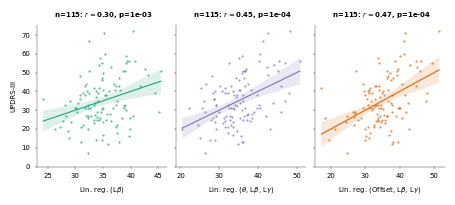

In [23]:
# Plot model comparison
y = 'UPDRS_III'
kinds = ['normalized', 'absolute', 'periodic']
xticklabels = [cfg.PLOT_LABELS[kind] for kind in kinds]
colors = [cfg.COLOR_DIC[kind] for kind in kinds]


fig, axes = plt.subplots(1, 3, figsize=(4.5, 2), sharey=True)

# Normalized
df_norm_off_ = df_norm_off[df_norm_off.sub_hemi.isin(df_per_off.sub_hemi.unique())]
X = ['beta_low_abs_mean_log']
r_linreg_rel, p_linreg_rel, ssr_rel1, dof_rel1, aic_rel, bic_rel = plot_all_ax(axes[0], df_norm_off_, X, y,
                                                                               'normalized', ylabel=True)

# Absolute
X = ['theta_abs_mean_log', 'beta_low_abs_mean_log', 'gamma_low_abs_mean_log']
df_abs_off_ = df_abs_off[df_abs_off.sub_hemi.isin(df_per_off.sub_hemi.unique())]
r_linreg_abs, p_linreg_abs, ssr_abs3, dof_abs3, aic_abs, bic_abs = plot_all_ax(axes[1], df_abs_off_, X, y, 'absolute')

# Periodic
X = ['fm_offset_log', 'beta_low_fm_mean_log', 'gamma_low_fm_mean_log']
r_linreg_per, p_linreg_per, ssr_per3, dof_per3, aic_per, bic_per = plot_all_ax(axes[2], df_per_off, X, y, 'periodic')

# f-test model comparison
pval_norm_abs = f_test(ssr_rel1, ssr_abs3, dof_rel1, dof_abs3, model_nme1='Normalized', model_nme2='Absolute')
pval_norm_per = f_test(ssr_rel1, ssr_per3, dof_rel1, dof_per3, model_nme1='Normalized', model_nme2='Periodic')
pval_abs_per = f_test(ssr_abs3, ssr_per3, dof_abs3, dof_per3, model_nme1='Absolute', model_nme2='Periodic')

annotations = [('normalized', 'absolute', pval_norm_abs),
                ('absolute', 'periodic', pval_abs_per),
                ('normalized', 'periodic', pval_norm_per)]
correlations = [r_linreg_rel, r_linreg_abs, r_linreg_per]
pvalues = [p_linreg_rel, p_linreg_abs, p_linreg_per]

axes[0].set_ylabel('UPDRS-III')
yticks = [0, 10, 20, 30, 40, 50, 60, 70]
axes[0].set_yticks(yticks, labels=yticks)
plt.tight_layout()
_save_fig(fig, 'Figure2/ch_dist_sweet/lin_regs.pdf', SAVE_DIR, close=False,
          bbox_inches=None, transparent=True)
# _save_fig(fig, 'Figure2/ch_dist_sweet/model_comparison.pdf', SAVE_DIR, close=False,
#           bbox_inches=None, transparent=True)

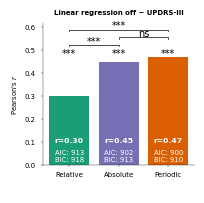

In [24]:

# Barplot model comparison
fig, ax = plt.subplots(1, 1, figsize=(2, 1.985))

ax.bar(x=xticklabels, height=correlations, color=colors)

# Statistics
bars = ax.containers[0]
ymin, ymax = ax.get_ylim()
yscale = np.abs(ymax - ymin)
y_buffer = 0.03*yscale
bar_x_coords = []
for i, bar in enumerate(bars):
    pvalue = pvalues[i]
    text = convert_pvalue_to_asterisks(pvalue)
    x_bar = bar.get_x() + bar.get_width() / 2
    bar_x_coords.append(bar.get_x())
    ax.annotate(text, xy=(x_bar, ymax + y_buffer), ha='center', va='top',
                fontsize=FONTSIZE_ASTERISK)

y_buffer = 0.02*yscale
height_stat = ymax + 1*y_buffer
# Loop through each annotation
for (x1_label, x2_label, pvalue) in annotations:
    # Get the indices of the bars from the 'kinds' list
    x1 = kinds.index(x1_label)
    x2 = kinds.index(x2_label)

    # Determine the y position for the line and asterisk
    y_line = height_stat + 1.5*y_buffer  # Add some offset for the line
    y_text = y_line

    # Draw the line connecting the two bars
    ax.plot([x1, x1, x2, x2],
            [y_line, y_line + y_buffer/2, y_line + y_buffer/2, y_line],
            color='black')

    # Get the significance text based on the p-value
    text = convert_pvalue_to_asterisks(pvalue, print_ns=True)

    # Place the text above the line
    ax.text((x1 + x2) / 2, y_text, text,
            ha='center', va='bottom', fontsize=FONTSIZE_ASTERISK)
    height_stat += 3.5*y_buffer

# Annotate AICc and BIC values in the center of the bars
aic_values = [aic_rel, aic_abs, aic_per]
bic_values = [bic_rel, bic_abs, bic_per]
for x, (aic, bic) in enumerate(zip(aic_values, bic_values)):
    corr = correlations[x]
    ax.text(x, .09,
        #     f'AIC: {aic:.0f}\nBIC: {bic:.0f}',
            f'r={corr:.2f}', ha='center', va='bottom',
            fontsize=5.5, fontweight='bold', color='w')
    ax.text(x, .008,
        #     f'AIC: {aic:.0f}\nBIC: {bic:.0f}',
            # f'r={corr:.2f}\n\nAIC: {aic:.0f}\nBIC: {bic:.0f}',
            f'AIC: {aic:.0f}\nBIC: {bic:.0f}',
            ha='center',
            va='bottom', fontsize=FONTSIZE_S,
            # fontweight='bold',
            color='w')

ax.set_ylabel(r"Pearson's $r$")
ax.set_title(f'Linear regression {cfg.COND_DICT['off']} ~ UPDRS-III',
             fontweight='bold', y=1)
ax.set_xlabel(r'$\alpha$ placeholder', alpha=0)
plt.tight_layout()
_save_fig(fig, 'Figure2/ch_dist_sweet/model_comparison.pdf', SAVE_DIR, close=False,
          bbox_inches=None, transparent=True)

In [25]:

# # Barplot model comparison
# fig, ax = plt.subplots(1, 1, figsize=(2, 1.985))

# ax.bar(x=xticklabels, height=correlations, color=colors)

# # Statistics
# bars = ax.containers[0]
# ymin, ymax = ax.get_ylim()
# yscale = np.abs(ymax - ymin)
# y_buffer = 0.03*yscale
# bar_x_coords = []
# for i, bar in enumerate(bars):
#     pvalue = pvalues[i]
#     text = convert_pvalue_to_asterisks(pvalue)
#     x_bar = bar.get_x() + bar.get_width() / 2
#     bar_x_coords.append(bar.get_x())
#     ax.annotate(text, xy=(x_bar, ymax + y_buffer), ha='center', va='top',
#                 fontsize=FONTSIZE_ASTERISK)

# y_buffer = 0.02*yscale
# height_stat = ymax + 1*y_buffer
# # Loop through each annotation
# for (x1_label, x2_label, pvalue) in annotations:
#     # Get the indices of the bars from the 'kinds' list
#     x1 = kinds.index(x1_label)
#     x2 = kinds.index(x2_label)

#     # Determine the y position for the line and asterisk
#     y_line = height_stat + 1.5*y_buffer  # Add some offset for the line
#     y_text = y_line

#     # Draw the line connecting the two bars
#     ax.plot([x1, x1, x2, x2],
#             [y_line, y_line + y_buffer/2, y_line + y_buffer/2, y_line],
#             color='black')

#     # Get the significance text based on the p-value
#     text = convert_pvalue_to_asterisks(pvalue, print_ns=True)

#     # Place the text above the line
#     ax.text((x1 + x2) / 2, y_text, text,
#             ha='center', va='bottom', fontsize=FONTSIZE_ASTERISK)
#     height_stat += 3.5*y_buffer

# # Annotate AICc and BIC values in the center of the bars
# aic_values = [aic_rel, aic_abs, aic_per]
# bic_values = [bic_rel, bic_abs, bic_per]
# for x, (aic, bic) in enumerate(zip(aic_values, bic_values)):
#     corr = correlations[x]
#     ax.text(x, -.14,
#             f'AIC: {aic:.0f}\nBIC: {bic:.0f}',
#             # f'r={corr:.2f}\n\nAIC: {aic:.0f}\nBIC: {bic:.0f}',
#             ha='center',
#             va='bottom', fontsize=FONTSIZE_S, color='k')

# ax.set_ylabel(r"Pearson's $r$")
# ax.set_title(f'Linear regression {cfg.COND_DICT['off']} ~ UPDRS-III',
#              fontweight='bold', y=1)
# ax.set_xlabel(r'$\alpha$ placeholder', alpha=0)
# plt.tight_layout()
# _save_fig(fig, 'Figure2/ch_dist_sweet/model_comparison2.pdf', SAVE_DIR, close=False,
#           bbox_inches=None, transparent=True)

In [26]:
# def ap_pwr(df, f_low=5, f_high=95):
#     # fm limits all projects
#     ap_pwr = df.fm_psd_ap_fit_log
#     freqs = df.fm_freqs
#     mask = (freqs >= f_low) & (freqs <= f_high)
#     return ap_pwr[mask].sum()
# # df_per = df_abs.dropna(subset=['fm_has_model', 'fm_psd_ap_fit_log'])
# df_abs_off['ap_power'] = df_abs_off.apply(ap_pwr, f_low=1, f_high=60, axis=1)

# X = ['ap_power', 'beta_low_fm_powers_max_log', 'gamma_low_fm_mean_log']
# plot_all(df_abs_off, X, y, 'periodic')

Huilings comment: multidimensional features only so nice in large datasets.

Result: Works also nice in single dataset.

In [27]:
# for project in df_abs_off.project.unique():
#     X = ['delta_theta_abs_max_log', 'beta_low_abs_max_log', 'gamma_low_abs_max_log']
#     plot_all(df_abs_off[df_abs_off.project == project], X, y, 'absolute', save=False)
#     X = ['fm_offset_log', 'beta_low_fm_powers_max_log', 'gamma_low_fm_mean_log']
#     plot_all(df_abs_off[df_abs_off.project == project], X, y, 'periodic', save=False)

### Interesting to keep in mind:

In [28]:
# X = ['fm_offset_log', 'beta_low_fm_powers_max_log', 'beta_highgamma_fm_stds_max']  # 25-45 Hz max. bandwidth
# plot_all(df_abs, X, y, 'periodic2')

# Plot UPDRS stun effect

In [29]:
df_abs = dataframes['df_abs']
df_abs = df_abs[~df_abs.project.isin(['all'])]
df_abs["UPDRS_III_prepost_diff"] = df_abs["UPDRS_pre_III"] - df_abs["UPDRS_post_III"]
x = 'patient_days_after_implantation'
y = 'UPDRS_III_prepost_diff'
df_abs = df_abs.dropna(subset=[x, y]).drop_duplicates(subset=['subject', 'cond', 'project'])
projects = df_abs.project_nme.unique()

/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_89760/268753191.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_abs["UPDRS_III_prepost_diff"] = df_abs["UPDRS_pre_III"] - df_abs["UPDRS_post_III"]
/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_89760/268753191.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abs["UPDRS_III_prepost_diff"] = df_abs["UPDRS_pre_III"] - df_abs["UPDRS_post_III"]


### Plot UPDRS post-pre vs days after implantation for Düsseldorf1 and Berlin data

/Users/moritzgerster/anaconda3/envs/aperiodic/lib/python3.12/site-packages/pingouin/effsize.py:402: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(x, y)[0]
/Users/moritzgerster/anaconda3/envs/aperiodic/lib/python3.12/site-packages/pingouin/effsize.py:402: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(x, y)[0]
/Users/moritzgerster/anaconda3/envs/aperiodic/lib/python3.12/site-packages/pingouin/effsize.py:402: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(x, y)[0]


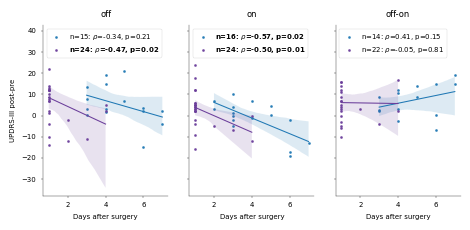

In [30]:
conds = ['off', 'on', 'offon_abs']
corr_method = 'spearman'
fig, axes = plt.subplots(1, len(conds), figsize=(4.7, 2.25), sharey=True)

for col, cond in enumerate(conds):
    ax = axes[col]
    ylabel = 'UPDRS-III post-pre' if col == 0 else None
    df_plot = df_abs[df_abs.cond.isin([cond])]
    plot_corr(ax, df_plot, x, y, hue="project",
              corr_method=corr_method, title=cfg.COND_DICT[cond], ci=95,
            xlabel='Days after surgery', scatter_kws={'s': 1})
    # modify legend entries
    weights = []
    for project in cfg.PROJECT_NAMES:
        if project in df_plot.project_nme.unique():
            corr_results = _corr_results(df_plot[df_plot.project_nme == project],
                                        x, y, corr_method, None, n_perm=n_perm)
            rho, sample_size, label, weight, _ = corr_results
            weights.append(weight)
    handles, labels = ax.get_legend_handles_labels()
    labels = [label.replace('Berlin ', '').replace('Düsseldorf1 ', '') for label in labels]
    leg = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(0, 1))
    [t.set_fontweight(w) for t, w in zip(leg.get_texts(), weights)]
    ax.set_title(cfg.COND_DICT[cond], fontsize=FONTSIZE_M)
    ax.set_ylabel(ylabel)

plt.tight_layout()
fname = f'stun_effect_UPDRS_vs_days_{'_'.join(conds)}.pdf'
save_dir = join(SAVE_DIR, 'Figure1/ch_dist_sweet/')
_save_fig(fig, fname, save_dir, bbox_inches=None, close=False, transparent=True)

## Pre vs post

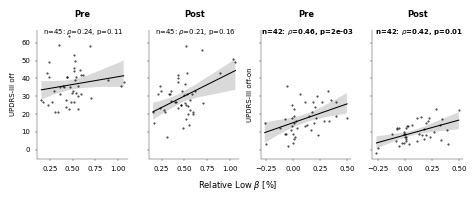

In [31]:
# average hemispheres
keep = ['subject', 'cond', 'project', 'color']
df_plot = df_norm_off.groupby(keep).mean(numeric_only=True).reset_index()

# get subjects who have both pre and post scores
# subjects_both =
# df_plot = df_norm_off[df_norm_off.subject.isin(subjects_both)]
y_pre = 'UPDRS_pre_III'
y_post = 'UPDRS_post_III'
x = 'beta_low_abs_max_log'
df_plot = df_plot.dropna(subset=[x, y_pre, y_post])

_, _, label_pre, weight, _ = _corr_results(df_plot, x, y_pre, corr_method, None,
                             n_perm=n_perm
                             )
_, _, label_post, weight, _ = _corr_results(df_plot, x, y_post, corr_method, None,
                             n_perm=n_perm
                             )

# df_plot = df_plot.dropna(subset=[x, y_pre, y_post])

# fig, axes = plt.subplots(2, 2, figsize=(2.25, 2.15), sharey="row")
fig, axes = plt.subplots(1, 4, figsize=(4.7, 2), sharey="row")

# ax = axes[0, 0]
ax = axes[0]
sns.regplot(ax=ax, data=df_plot, y=y_pre, x=x, ci=95, scatter_kws=dict(s=1),
            color='k', label=label_pre, marker='.', n_boot=1000)

y_title = 0.9
ax.text(0.5, 1.1, 'Pre', ha='center', fontsize=FONTSIZE_M,
        transform=ax.transAxes, fontweight='bold')
ax.set_title(label_pre, weight=weight, y=y_title)
# band_nme = x.replace('_abs_max_log', '')
# band_nme = cfg.BAND_NAMES_GREEK[band_nme]
# ax.set_xlabel(f'Relative {band_nme} Peak [%]')
ax.set_xlabel(None)
ax.set_ylabel('UPDRS-III off')

# ax = axes[0, 1]
ax = axes[1]
sns.regplot(ax=ax, data=df_plot, y=y_post, x=x, ci=95, scatter_kws=dict(s=1),
            color='k', label=label_post, marker='.', n_boot=1000)

ax.text(0.5, 1.1, 'Post', ha='center', fontsize=FONTSIZE_M,
        transform=ax.transAxes, fontweight='bold')
ax.set_title(label_post, weight=weight, y=y_title)
# band_nme = x.replace('_abs_max_log', '')
# band_nme = cfg.BAND_NAMES_GREEK[band_nme]
# ax.set_xlabel(f'Relative {band_nme} Peak [%]')
ax.set_xlabel(None)
ax.set_ylabel(None)
# ax.set_ylabel('UPDRS-III Post-operative off')

# plt.tight_layout()
# fname = 'norm_beta_low_vs_UPDRS_off_prepost.pdf'
# save_dir = join(SAVE_DIR, 'Figure1', 'ch_dist_sweet')
# _save_fig(fig, fname, save_dir, bbox_inches=None, close=False, transparent=True)

# average hemispheres
keep = ['subject', 'cond', 'project', 'color']
df_plot = df_norm_offon.groupby(keep).mean(numeric_only=True).reset_index()

# get subjects who have both pre and post scores
# subjects_both =
# df_plot = df_norm_off[df_norm_off.subject.isin(subjects_both)]
# y_pre = 'UPDRS_pre_III'
# y_post = 'UPDRS_post_III'
df_plot = df_plot.dropna(subset=[x, y_pre, y_post])

_, _, label_pre, weight, _ = _corr_results(df_plot, x, y_pre, corr_method, None,
                             n_perm=n_perm
                             )
_, _, label_post, weight, _ = _corr_results(df_plot, x, y_post, corr_method, None,
                             n_perm=n_perm
                             )

# df_plot = df_plot.dropna(subset=[x, y_pre, y_post])

# fig, axes = plt.subplots(1, 2, figsize=(2.6, 1.3), sharey=True)

# ax = axes[1, 0]
ax = axes[2]
sns.regplot(ax=ax, data=df_plot, y=y_pre, x=x, ci=95, scatter_kws=dict(s=1),
            color='k', label=label_pre, marker='.', n_boot=1000)

ax.text(0.5, 1.1, 'Pre', ha='center', fontsize=FONTSIZE_M,
        transform=ax.transAxes, fontweight='bold')
ax.set_title(label_pre, weight=weight, y=y_title)
band_nme = x.replace('_abs_max_log', '')
band_nme = cfg.BAND_NAMES_GREEK[band_nme]
ax.set_xlabel(None)
# ax.set_xlabel(f'Relative {band_nme} [%]')
# ax.set_ylabel('UPDRS-III Pre-operative off-on')
ax.set_ylabel('UPDRS-III off-on')

# ax = axes[1, 1]
ax = axes[3]
sns.regplot(ax=ax, data=df_plot, y=y_post, x=x, ci=95, scatter_kws=dict(s=1),
            color='k', label=label_post, marker='.', n_boot=1000)

# label_post = 'Post\n' + label_post
# ax.legend()
ax.set_title(label_post, weight=weight, y=y_title)
ax.text(0.5, 1.1, 'Post', ha='center', fontsize=FONTSIZE_M,
        transform=ax.transAxes, fontweight='bold')
band_nme = x.replace('_abs_max_log', '')
band_nme = cfg.BAND_NAMES_GREEK[band_nme]
ax.set_xlabel(None)
fig.supxlabel(f'Relative {band_nme} [%]', y=0.04)
# ax.set_ylabel('UPDRS-III Post-operative off-on')
ax.set_ylabel(None)

plt.tight_layout()
fname = 'norm_beta_low_vs_UPDRS_offon_off_prepost.pdf'
save_dir = join(SAVE_DIR, 'Figure1', 'ch_dist_sweet')
_save_fig(fig, fname, save_dir, bbox_inches=None, close=False, transparent=True)